**EmotionNet**

Facial Emotion Recognition

(FER-2013-https://www.kaggle.com/datasets/msambare/fer2013)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages
!pip install tensorflow keras opencv-python matplotlib

# Import necessary libraries for the project
import numpy as np                # For numerical operations (e.g., arrays)
import tensorflow as tf           # Import TensorFlow for machine learning tasks
from tensorflow.keras.models import Sequential    # Import Sequential model for building neural networks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Import specific layers for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
import matplotlib.pyplot as plt   # For plotting graphs and images
import cv2                        # For image processing tasks
import os                         # For interacting with the file system (e.g., directories)


In [ ]:
# Import necessary libraries for file handling and splitting dataset
import os                             # For interacting with the file system (directories, file operations)
import shutil                         # For moving files between directories
from sklearn.model_selection import train_test_split   # For splitting dataset into train and validation sets

# Define the paths to the training and validation directories
train_dir = "/content/drive/MyDrive/cvpr project/train"            # Path to the training dataset
validation_dir = "/content/drive/MyDrive/emotion-detection/validation"  # Path to the validation dataset

# Create the validation directory if it doesn't exist
os.makedirs(validation_dir, exist_ok=True)

# Get the list of class directories from the training set
class_dirs = os.listdir(train_dir)  # List of directories (each representing a class of images)

# Loop over each class directory
for class_name in class_dirs:
    # Construct the path to the current class directory within the training data
    class_path = os.path.join(train_dir, class_name)

    # Get all image files in the current class directory
    images = os.listdir(class_path)

    # If the directory is empty, skip it and print a message
    if len(images) == 0:
        print(f"Skipping empty directory: {class_path}")
        continue

    # Split the images into training and validation sets (80% train, 20% validation)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create a directory for the class in the validation folder if it doesn't exist
    val_class_dir = os.path.join(validation_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)

    # Move the images selected for validation into the validation directory
    for img in val_images:
        # Construct the full paths for the source (training set) and destination (validation set)
        src_path = os.path.join(class_path, img)
        dst_path = os.path.join(val_class_dir, img)

        # Move the image from training to validation set
        shutil.move(src_path, dst_path)  # Move the file from the training set to the validation set


In [ ]:
# Define the paths for the training and validation datasets
train_dir = "/content/drive/MyDrive/cvpr project/train"            # Path to the training dataset
validation_dir = "/content/drive/MyDrive/emotion-detection/validation"  # Path to the validation dataset

# Create an instance of ImageDataGenerator for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Rescale the pixel values to the range [0, 1]
    rotation_range=30,               # Randomly rotate images in the range (30 degrees)
    width_shift_range=0.2,           # Randomly shift images horizontally by 20%
    height_shift_range=0.2,          # Randomly shift images vertically by 20%
    shear_range=0.2,                 # Randomly apply shear transformations to the images
    zoom_range=0.2,                  # Randomly zoom into images by 20%
    horizontal_flip=True             # Randomly flip images horizontally
)

# Create an instance of ImageDataGenerator for the validation dataset (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values for validation

# Create the training data generator that will load and augment images in batches from the training directory
train_generator = train_datagen.flow_from_directory(
    train_dir,                    # Path to the training dataset directory
    target_size=(48, 48),         # Resize images to 48x48 pixels
    batch_size=64,                # Number of images to process in each batch
    color_mode='grayscale',       # Convert images to grayscale (1 channel)
    class_mode='categorical'      # Use categorical labels (one-hot encoding for class labels)
)

# Create the validation data generator that will load images in batches from the validation directory
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,               # Path to the validation dataset directory
    target_size=(48, 48),         # Resize images to 48x48 pixels
    batch_size=64,                # Number of images to process in each batch
    color_mode='grayscale',       # Convert images to grayscale (1 channel)
    class_mode='categorical'      # Use categorical labels (one-hot encoding for class labels)
)


Found 22965 images belonging to 7 classes.
Found 5744 images belonging to 7 classes.


In [ ]:
# Import ImageDataGenerator from Keras for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    # Rescale pixel values to the range [0, 1]
    rescale=1./255,

    # Set aside 20% of the data for validation (validation split)
    validation_split=0.2,

    # Apply random rotation to images (up to 30 degrees)
    rotation_range=30,

    # Apply random horizontal or vertical shifts within 20% of the image width
    width_shift_range=0.2,

    # Apply random vertical shifts within 20% of the image height
    height_shift_range=0.2,

    # Apply random shear transformation (shear angle up to 20%)
    shear_range=0.2,

    # Apply random zoom transformation (zoom within 20% of original size)
    zoom_range=0.2,

    # Randomly flip images horizontally
    horizontal_flip=True
)

# Generator for the training set with augmented data
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to the directory where the training images are stored
    target_size=(48, 48),  # Resize images to 48x48 pixels
    batch_size=64,  # Number of images to process in each batch
    color_mode='grayscale',  # Load images in grayscale
    class_mode='categorical',  # Use categorical labels for classification
    subset='training'  # Indicate that this is for the training subset (defined by validation_split)
)

# Generator for the validation set (data split based on validation_split parameter)
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to the directory where the validation images are stored
    target_size=(48, 48),  # Resize images to 48x48 pixels
    batch_size=64,  # Number of images to process in each batch
    color_mode='grayscale',  # Load images in grayscale
    class_mode='categorical',  # Use categorical labels for classification
    subset='validation'  # Indicate that this is for the validation subset (defined by validation_split)
)


Found 18375 images belonging to 7 classes.
Found 4590 images belonging to 7 classes.


In [ ]:
# Initialize a Sequential model
model = Sequential([

    # First Convolutional Layer: 32 filters, 3x3 kernel, ReLU activation function
    # Input shape is (48, 48, 1) for grayscale images of size 48x48
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),

    # MaxPooling Layer: Reduces the spatial dimensions (downsampling) by taking the max value in each 2x2 pool
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer: 64 filters, 3x3 kernel, ReLU activation function
    Conv2D(64, (3, 3), activation='relu'),

    # MaxPooling Layer: Similar to the previous MaxPooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer: 128 filters, 3x3 kernel, ReLU activation function
    Conv2D(128, (3, 3), activation='relu'),

    # MaxPooling Layer: Reduces spatial size after third convolutional layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten Layer: Converts the 3D feature maps into a 1D vector to be passed to the fully connected (Dense) layer
    Flatten(),

    # Fully Connected Layer (Dense): 128 neurons, ReLU activation function
    Dense(128, activation='relu'),

    # Dropout Layer: 50% of the neurons are randomly turned off to prevent overfitting
    Dropout(0.5),

    # Output Layer: 7 neurons for 7 classes (multi-class classification), softmax activation for probability distribution
    Dense(7, activation='softmax')
])

# Compile the model with the Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Import necessary libraries for deep learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths to training and test directories
train_dir = "/content/drive/MyDrive/cvpr project/train"
test_dir = "/content/drive/MyDrive/cvpr project/test"

# Data augmentation for training set to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1] range
    rotation_range=30,  # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Randomly shear images (shear angle range)
    zoom_range=0.2,  # Randomly zoom into images by 20%
    horizontal_flip=True  # Randomly flip images horizontally
)

# Test data preprocessing, only rescaling the pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with augmentation, images are resized to 48x48, grayscale, and categorical labels
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Batch size of 64 images
    color_mode='grayscale',  # Load images in grayscale
    class_mode='categorical'  # Use categorical encoding for labels
)

# Load test data without augmentation (only rescaling)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Batch size of 64 images
    color_mode='grayscale',  # Load images in grayscale
    class_mode='categorical'  # Use categorical encoding for labels
)

# Define the CNN architecture
model = Sequential([
    # Convolutional Layer: 32 filters of size 3x3, ReLU activation, input shape for grayscale images (48x48, 1 channel)
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),

    # MaxPooling Layer: 2x2 pool size to reduce spatial dimensions (downsampling)
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer: 64 filters of size 3x3, ReLU activation
    Conv2D(64, (3, 3), activation='relu'),

    # MaxPooling Layer: 2x2 pool size for downsampling
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer: 128 filters of size 3x3, ReLU activation
    Conv2D(128, (3, 3), activation='relu'),

    # MaxPooling Layer: 2x2 pool size for downsampling
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten Layer: Flatten the 3D output from the previous layers into a 1D vector
    Flatten(),

    # Fully connected Dense Layer: 128 neurons with ReLU activation
    Dense(128, activation='relu'),

    # Dropout Layer: 50% of the neurons are randomly dropped to prevent overfitting
    Dropout(0.5),

    # Output Layer: 7 neurons (one for each class), softmax activation to output probabilities
    Dense(7, activation='softmax')
])

# Compile the model: Using Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the training and validation data generators
model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    validation_data=test_generator,  # Validation data generator
    validation_steps=test_generator.samples // test_generator.batch_size,  # Number of validation steps
    epochs=50  # Number of epochs for training
)

# Save the trained model to a file
model.save('/content/drive/MyDrive/emotiondataset/emotion_detection_model.h5')


Found 22965 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 150s 311ms/step - accuracy: 0.2303 - loss: 1.8366 - val_accuracy: 0.2535 - val_loss: 1.7849
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.2656 - loss: 1.8543 - val_accuracy: 0.1000 - val_loss: 1.9201
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 144s 300ms/step - accuracy: 0.2490 - loss: 1.7996 - val_accuracy: 0.2563 - val_loss: 1.7554
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.2812 - loss: 1.7150 - val_accuracy: 0.0000e+00 - val_loss: 1.7605
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 141s 298ms/step - accuracy: 0.2561 - loss: 1.7782 - val_accuracy: 0.2958 - val_loss: 1.7203
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 108us/step - accuracy: 0.3438 - loss: 1.6103 - val_accuracy: 0.3000 - val_loss: 1.6184
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 110s 302ms/step - accuracy: 0.2759 - loss: 1.7551 - val_accuracy: 0.3150 - val_loss: 1

In [ ]:
# Import necessary libraries for deep learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths to the training and test directories
train_dir = "/content/drive/MyDrive/cvpr project/train"
test_dir = "/content/drive/MyDrive/cvpr project/test"

# Load the pre-trained model from the specified file path
model_path = '/content/drive/MyDrive/emotiondataset/emotion_detection_model.h5'
model = load_model(model_path)

# Compile the loaded model with Adam optimizer and categorical crossentropy loss function
# This is necessary in case we are further training the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation for the training set to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1] range
    rotation_range=30,  # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Randomly shear images (shear angle range)
    zoom_range=0.2,  # Randomly zoom into images by 20%
    horizontal_flip=True  # Randomly flip images horizontally
)

# Test data preprocessing, only rescaling the pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data with augmentation, images are resized to 48x48, grayscale, and categorical labels
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Batch size of 64 images
    color_mode='grayscale',  # Load images in grayscale
    class_mode='categorical'  # Use categorical encoding for labels
)

# Load the test data without augmentation (only rescaling)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Batch size of 64 images
    color_mode='grayscale',  # Load images in grayscale
    class_mode='categorical'  # Use categorical encoding for labels
)

# Define the number of additional epochs to continue training
additional_epochs = 25

# Continue training the model with the training and validation data generators
# 'initial_epoch' is set to 50 to continue from the previously trained epoch
model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    validation_data=test_generator,  # Validation data generator
    validation_steps=test_generator.samples // test_generator.batch_size,  # Number of validation steps
    epochs=additional_epochs,  # Additional epochs to train the model
    initial_epoch=50  # Continue training from epoch 50 (from the previous training)
)

# Save the further trained model to a new file
model.save('/content/drive/MyDrive/emotiondataset/emotion_detection_model_further_trained.h5')

# Print message indicating that the model has been trained and saved
print("Model training completed and saved.")


Found 22965 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model training completed and saved.


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths to the training and test directories
train_dir = "/content/drive/MyDrive/cvpr project/train"
test_dir = "/content/drive/MyDrive/cvpr project/test"

# Load the pre-trained model
model_path = '/content/drive/MyDrive/emotiondataset/emotion_detection_model.h5'
model = load_model(model_path)

# Compile the loaded model with Adam optimizer and categorical crossentropy loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation for the training set to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to the range [0, 1]
    rotation_range=30,  # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Randomly shear images (shear angle range)
    zoom_range=0.2,  # Randomly zoom into images by 20%
    horizontal_flip=True  # Randomly flip images horizontally
)

# Test data preprocessing, only rescaling the pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from the specified directory, apply augmentation, and resize images to 48x48
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Set batch size to 64
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='categorical'  # Use categorical labels (one-hot encoded)
)

# Load test data from the specified directory, only apply rescaling
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Set batch size to 64
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='categorical'  # Use categorical labels (one-hot encoded)
)

# Define the number of additional epochs to continue training
additional_epochs = 25

# Continue training the model with the training and validation data generators
model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    validation_data=test_generator,  # Validation data generator
    validation_steps=test_generator.samples // test_generator.batch_size,  # Number of validation steps
    epochs=additional_epochs,  # Additional epochs for training
    initial_epoch=50  # Start training from epoch 50 (resume from the previous training)
)

# Save the trained model in Keras format
model.save('/content/drive/MyDrive/emotiondataset/emotion_detection_model_further_trained.keras', save_format='keras')

# Print message indicating that the model has been trained and saved
print("Model training completed and saved.")


Found 22965 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model training completed and saved.


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image  # For image file verification

# Set the path to the test directory where images are stored
test_dir = "/content/drive/MyDrive/cvpr project/test"

# Load the pre-trained model that was further trained
model_path = '/content/drive/MyDrive/emotiondataset/emotion_detection_model_further_trained.keras'
model = load_model(model_path)

# Initialize ImageDataGenerator to rescale pixel values to the range [0, 1] for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Function to clean the test directory by removing invalid images (corrupted files)
def clean_invalid_images(directory):
    # Walk through the directory and all its subdirectories
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                # Try to open the image and verify if it's a valid image
                img = Image.open(filepath)
                img.verify()  # Verifies the image without fully opening it
            except (IOError, SyntaxError):  # Catch errors if the image is invalid
                print(f"Removing invalid image: {filepath}")  # Print the invalid file path
                os.remove(filepath)  # Remove the invalid image from the directory

# Clean the test directory by removing invalid images
clean_invalid_images(test_dir)

# Load test data from the directory, rescale images, and resize them to 48x48 pixels
# `shuffle=False` ensures that the order of test images remains the same
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),  # Resize all images to 48x48
    batch_size=64,  # Set batch size to 64
    color_mode='grayscale',  # Load images as grayscale
    class_mode='categorical',  # Use categorical labels (one-hot encoding)
    shuffle=False  # Ensure test data is not shuffled for consistency in evaluation
)

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(
    test_generator,  # The test data generator
    steps=test_generator.samples // test_generator.batch_size  # Steps per epoch (total test samples / batch size)
)

# Print the results of the evaluation
print(f"Test Loss: {loss:.4f}")  # Print loss to 4 decimal places
print(f"Test Accuracy: {accuracy * 100:.2f}%")  # Print accuracy as a percentage with 2 decimal places


Removing invalid image: /content/drive/MyDrive/cvpr project/test/angry/PrivateTest_10131363.jpg
Found 7177 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.4901 - loss: 1.3023
Test Loss: 1.2017
Test Accuracy: 54.16%


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


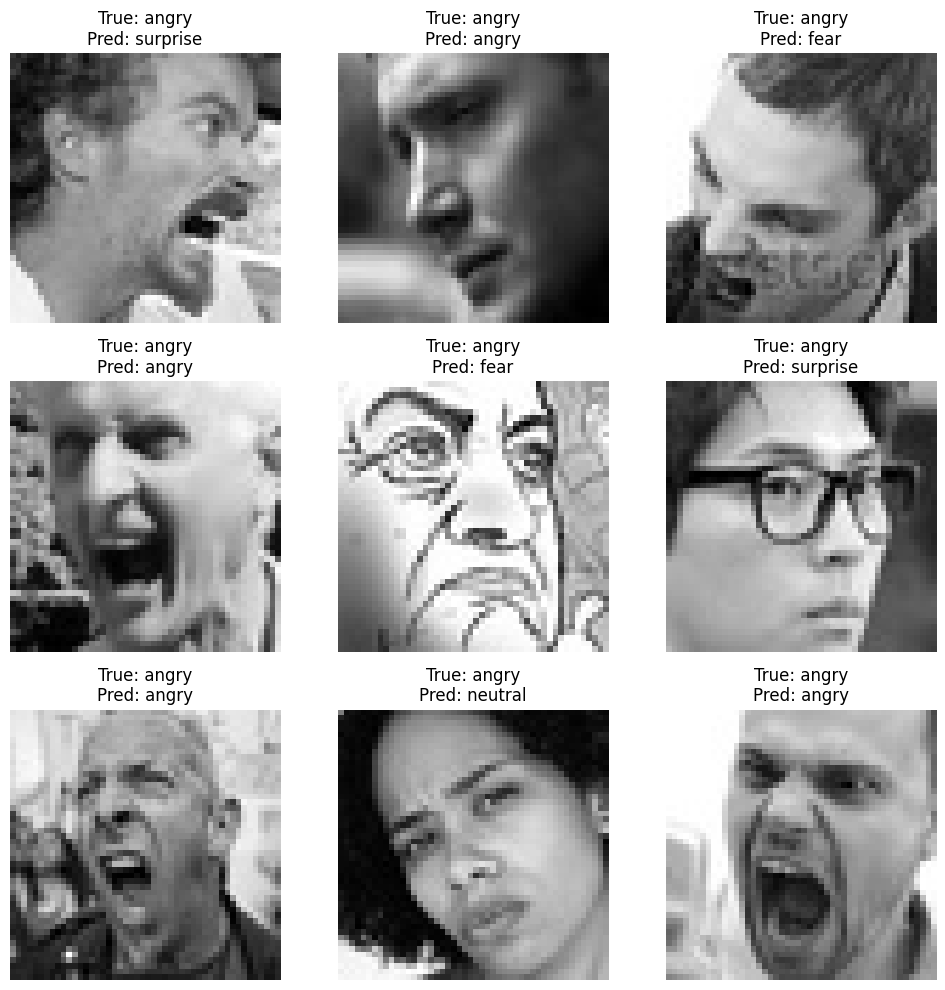

In [ ]:
import matplotlib.pyplot as plt  # Importing the matplotlib library for plotting images

# Reset the test generator for fresh predictions
# This ensures that we are starting from the first batch in the test set
test_generator.reset()

# Fetch a batch of data from the test generator
# This will return a batch of images and their corresponding labels
images, labels = next(test_generator)

# Make predictions using the model on the batch of images
# The model outputs probabilities for each class, so we need to take the class with the highest probability
predictions = model.predict(images)

# Convert the predicted probabilities to class labels by taking the index of the highest probability for each image
# np.argmax returns the index of the maximum value along an axis, in this case, the axis of class probabilities (axis=1)
predicted_classes = np.argmax(predictions, axis=1)

# Convert the true labels from one-hot encoding to class indices (from one-hot vectors to integers)
# np.argmax is used here to get the index of the '1' in each one-hot vector, which corresponds to the true class label
true_classes = np.argmax(labels, axis=1)

# Get the class labels from the test generator's 'class_indices' dictionary
# This will give us the class names corresponding to the integer class indices
class_labels = list(test_generator.class_indices.keys())

# Plot some images with predictions
plt.figure(figsize=(10, 10))  # Create a figure with a size of 10x10 inches for a large grid

# Loop through the first 9 images in the batch (for visualization purposes)
for i in range(9):
    # Create a subplot for each image (3x3 grid)
    plt.subplot(3, 3, i + 1)

    # Display the image in grayscale (reshaped to 48x48 for proper display)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')

    # Set the title to show the true and predicted class labels for the current image
    plt.title(f"True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}")

    # Hide the axes for a cleaner image display
    plt.axis('off')

# Adjust layout to make sure there's no overlap between the subplots
plt.tight_layout()

# Show the plot with all the images and their predictions
plt.show()
